In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import os
import warnings
warnings.filterwarnings('ignore')

In [51]:
path="D:\Python\Elo"
df_train = pd.read_csv(os.path.join(path,'main.csv'))
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
def test_result(df):
    data=df[['feature_1', 'feature_2', 'feature_3','target']]
    from sklearn.linear_model import Ridge
    model=Ridge()
    model.fit(data.loc[:,data.columns!='target'],data['target'])
    pr=model.predict(data.loc[:,data.columns!='target'])
    return np.sqrt(mean_squared_error(pr,data['target']))
df_train=reduce_mem_usage(df_train)

Mem. usage decreased to 151.74 Mb (66.3% reduction)


In [48]:
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dot, Reshape, Add, Subtract
from keras import objectives
from keras import backend as K
from keras import regularizers 
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
def FM(df,features):
    f_size=[int(df[f].max())+1 for f in features]
    train,val=train_test_split(df,test_size=0.25,random_state=900)
    train_x=train.groupby(features)['target'].count()
    train_x = train_x.unstack().fillna(0)
    train_x = train_x.stack().astype('float32')
    train_x=np.log1p(train_x).reset_index()
    train_x.columns=features+['num']
    train_data=train_x.copy()
    train_y=(train_x[['num']].values).astype('float32')
    train_x=[train_x[f].values for f in features]
    
    val_x=val.groupby(features)['target'].count()
    val_x = val_x.unstack().fillna(0)
    val_x = val_x.stack().astype('float32')
    val_x=np.log1p(val_x).reset_index()
    val_x.columns=features+['num']
    val_y=(val_x[['num']].values).astype('float32')
    val_x=[val_x[f].values for f in features]
    
    k_latent = 2
    embedding_reg = 0.0002
    kernel_reg = 0.1

    def get_embed(x_input, x_size, k_latent):
        if x_size > 0: #category
            embed = Embedding(x_size, k_latent, input_length=1, 
                              embeddings_regularizer=l2(embedding_reg))(x_input)
            embed = Flatten()(embed)
        else:
            embed = Dense(k_latent, kernel_regularizer=l2(embedding_reg))(x_input)
        return embed
    def build_model_1(X, f_size):
        dim_input = len(f_size)

        input_x = [Input(shape=(1,)) for i in range(dim_input)] 

        biases = [get_embed(x, size, 1) for (x, size) in zip(input_x, f_size)]

        factors = [get_embed(x, size, k_latent) for (x, size) in zip(input_x, f_size)]

        s = Add()(factors)

        diffs = [Subtract()([s, x]) for x in factors]

        dots = [Dot(axes=1)([d, x]) for d,x in zip(diffs, factors)]

        x = Concatenate()(biases + dots)
        x = BatchNormalization()(x)
        output = Dense(1, activation='relu', kernel_regularizer=l2(kernel_reg))(x)
        model = Model(inputs=input_x, outputs=[output])
        opt = Adam(clipnorm=0.5)
        model.compile(optimizer=opt, loss='mean_squared_error')
        output_f = factors + biases
        model_features = Model(inputs=input_x, outputs=output_f)
        return model, model_features
    n_epochs = 300
    P = 17

    batch_size = 2**P
    model, model_features = build_model_1(train_x, f_size)
    earlystopper = EarlyStopping(patience=0, verbose=1)

    model.fit(train_x, train_y, 
              epochs=n_epochs, batch_size=batch_size, verbose=1, shuffle=True, 
              validation_data=(val_x, val_y),
              callbacks=[earlystopper],
             )
    pred_x = model_features.predict(train_x, batch_size=batch_size)
    factors = pred_x[:len(features)]
    biases = pred_x[len(features):2*len(features)]

    for f, x_p in zip(features, factors):
        for i in range(k_latent):
            train_data['%s_fm_factor_%d' % (f, i)] = x_p[:,i]

    for f, x_p in zip(features, biases):
        train_data['%s_fm_bias' % (f)] = x_p[:,0]
    df=df.merge(train_data.loc[:,train_data.columns!='num'],how='left',on=features)
    return df


In [54]:
from sklearn.cluster import KMeans
kmeans=KMeans().fit(df_train[['hist_purchase_amount_mean','hist_purchase_date_uptonow','hist_card_id_size']])
df_train['RFM']=kmeans.labels_
df_train['card_id_cnt_ratio']=df_train['card_id_cnt_ratio'].fillna(0)
kmeans=KMeans().fit(df_train[['hist_authorized_flag_mean','hist_category_1_sum','card_id_cnt_ratio','hist_Children_day_2017_mean']])
df_train['DiffFactors']=kmeans.labels_

In [49]:
df_train=FM(df_train,['feature_1', 'DiffFactors','RFM'])

Train on 288 samples, validate on 252 samples
Epoch 1/300
288/288 [==============================] - 2s 7ms/step - loss: 18.1380 - val_loss: 13.7427
Epoch 2/300
288/288 [==============================] - 0s 0us/step - loss: 18.0494 - val_loss: 13.6678
Epoch 3/300
288/288 [==============================] - 0s 54us/step - loss: 17.9612 - val_loss: 13.5931
Epoch 4/300
288/288 [==============================] - 0s 0us/step - loss: 17.8727 - val_loss: 13.5175
Epoch 5/300
288/288 [==============================] - 0s 0us/step - loss: 17.7812 - val_loss: 13.4400
Epoch 6/300
288/288 [==============================] - 0s 0us/step - loss: 17.6884 - val_loss: 13.3615
Epoch 7/300
288/288 [==============================] - 0s 0us/step - loss: 17.5950 - val_loss: 13.2822
Epoch 8/300
288/288 [==============================] - 0s 162us/step - loss: 17.5007 - val_loss: 13.2026
Epoch 9/300
288/288 [==============================] - 0s 54us/step - loss: 17.4062 - val_loss: 13.1229
Epoch 10/300
288/288 [=

Epoch 80/300
288/288 [==============================] - 0s 0us/step - loss: 12.2949 - val_loss: 9.2925
Epoch 81/300
288/288 [==============================] - 0s 54us/step - loss: 12.2634 - val_loss: 9.2709
Epoch 82/300
288/288 [==============================] - 0s 0us/step - loss: 12.2320 - val_loss: 9.2500
Epoch 83/300
288/288 [==============================] - 0s 54us/step - loss: 12.2010 - val_loss: 9.2297
Epoch 84/300
288/288 [==============================] - 0s 0us/step - loss: 12.1708 - val_loss: 9.2099
Epoch 85/300
288/288 [==============================] - 0s 54us/step - loss: 12.1387 - val_loss: 9.1907
Epoch 86/300
288/288 [==============================] - 0s 0us/step - loss: 12.1051 - val_loss: 9.1720
Epoch 87/300
288/288 [==============================] - 0s 54us/step - loss: 12.0684 - val_loss: 9.1540
Epoch 88/300
288/288 [==============================] - 0s 0us/step - loss: 12.0305 - val_loss: 9.1366
Epoch 89/300
288/288 [==============================] - 0s 54us/step 

Epoch 159/300
288/288 [==============================] - 0s 54us/step - loss: 6.1736 - val_loss: 4.3325
Epoch 160/300
288/288 [==============================] - 0s 0us/step - loss: 6.0811 - val_loss: 4.2379
Epoch 161/300
288/288 [==============================] - 0s 0us/step - loss: 5.9879 - val_loss: 4.1457
Epoch 162/300
288/288 [==============================] - 0s 0us/step - loss: 5.8945 - val_loss: 4.0539
Epoch 163/300
288/288 [==============================] - 0s 0us/step - loss: 5.8019 - val_loss: 3.9630
Epoch 164/300
288/288 [==============================] - 0s 54us/step - loss: 5.7099 - val_loss: 3.8684
Epoch 165/300
288/288 [==============================] - 0s 0us/step - loss: 5.6170 - val_loss: 3.7715
Epoch 166/300
288/288 [==============================] - 0s 54us/step - loss: 5.5259 - val_loss: 3.6767
Epoch 167/300
288/288 [==============================] - 0s 54us/step - loss: 5.4360 - val_loss: 3.5842
Epoch 168/300
288/288 [==============================] - 0s 0us/step 

In [55]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
obj=list(df_train.select_dtypes(include=['object']).columns)[2:]
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
for o in obj:
    df_train[o]=lb.fit_transform(df_train[o]) 
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers','Unnamed: 0','Unnamed: 0_x']]
param = {'objective': 'regression_l2', 
            'boosting_type': 'gbdt', 
            'n_jobs': 4, 'max_depth': 7, 
            'n_estimators': 20000, 
            'subsample_freq': 2, 
            'subsample_for_bin': 200000, 
            'min_data_per_group': 100, 
            'max_cat_to_onehot': 4, 
            'cat_l2': 10.0, 
            'cat_smooth': 10.0, 
            'max_cat_threshold': 32, 
            'metric_freq': 10, 
            'verbosity': -1, 
            'metric': 'rmse', 
            'colsample_bytree': 0.5, 
            'learning_rate': 0.0061033234451294376, 
            'min_child_samples': 80, 
            'min_child_weight': 100.0, 
            'min_split_gain': 1e-06, 
            'num_leaves': 47, 
            'reg_alpha': 10.0, 
            'reg_lambda': 10.0, 
            'subsample': 0.9}
rskf=StratifiedKFold(5,shuffle=True,random_state=4590)
val_pr=np.zeros(len(df_train))
feature_importance_df = pd.DataFrame()
#test_pr=np.zeros(len(df_test))
for train_index,val_index in rskf.split(df_train,df_train['outliers'].values):
    train_data=lgb.Dataset(df_train[df_train_columns].loc[train_index],label=df_train['target'].loc[train_index])
    val_data=lgb.Dataset(df_train[df_train_columns].loc[val_index],label=df_train['target'].loc[val_index])
    num_round = 10000
    model=lgb.train(param,train_data,num_round,valid_sets=[train_data,val_data],verbose_eval=100,early_stopping_rounds=400)
    fold_importance_df=pd.DataFrame()
    fold_importance_df['feature'] = df_train_columns
    fold_importance_df['importance']=model.feature_importance()
    feature_importance_df=pd.concat([feature_importance_df,fold_importance_df],axis=0)
    
    val_pr[val_index]=model.predict(df_train[df_train_columns].loc[val_index],num_iteration=model.best_iteration)
np.sqrt(mean_squared_error(val_pr,df_train['target']))

Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.71849	valid_1's rmse: 3.74983
[200]	training's rmse: 3.65332	valid_1's rmse: 3.70211
[300]	training's rmse: 3.61346	valid_1's rmse: 3.67989
[400]	training's rmse: 3.58488	valid_1's rmse: 3.66785
[500]	training's rmse: 3.56318	valid_1's rmse: 3.66036
[600]	training's rmse: 3.54467	valid_1's rmse: 3.6556
[700]	training's rmse: 3.52985	valid_1's rmse: 3.65265
[800]	training's rmse: 3.51587	valid_1's rmse: 3.65033
[900]	training's rmse: 3.50295	valid_1's rmse: 3.64851
[1000]	training's rmse: 3.49059	valid_1's rmse: 3.64726
[1100]	training's rmse: 3.47927	valid_1's rmse: 3.64588
[1200]	training's rmse: 3.46821	valid_1's rmse: 3.64515
[1300]	training's rmse: 3.45791	valid_1's rmse: 3.64421
[1400]	training's rmse: 3.44739	valid_1's rmse: 3.64377
[1500]	training's rmse: 3.4379	valid_1's rmse: 3.64362
[1600]	training's rmse: 3.42894	valid_1's rmse: 3.64342
[1700]	training's rmse: 3.4199	valid_1's rmse: 3.643

3.650035994430912

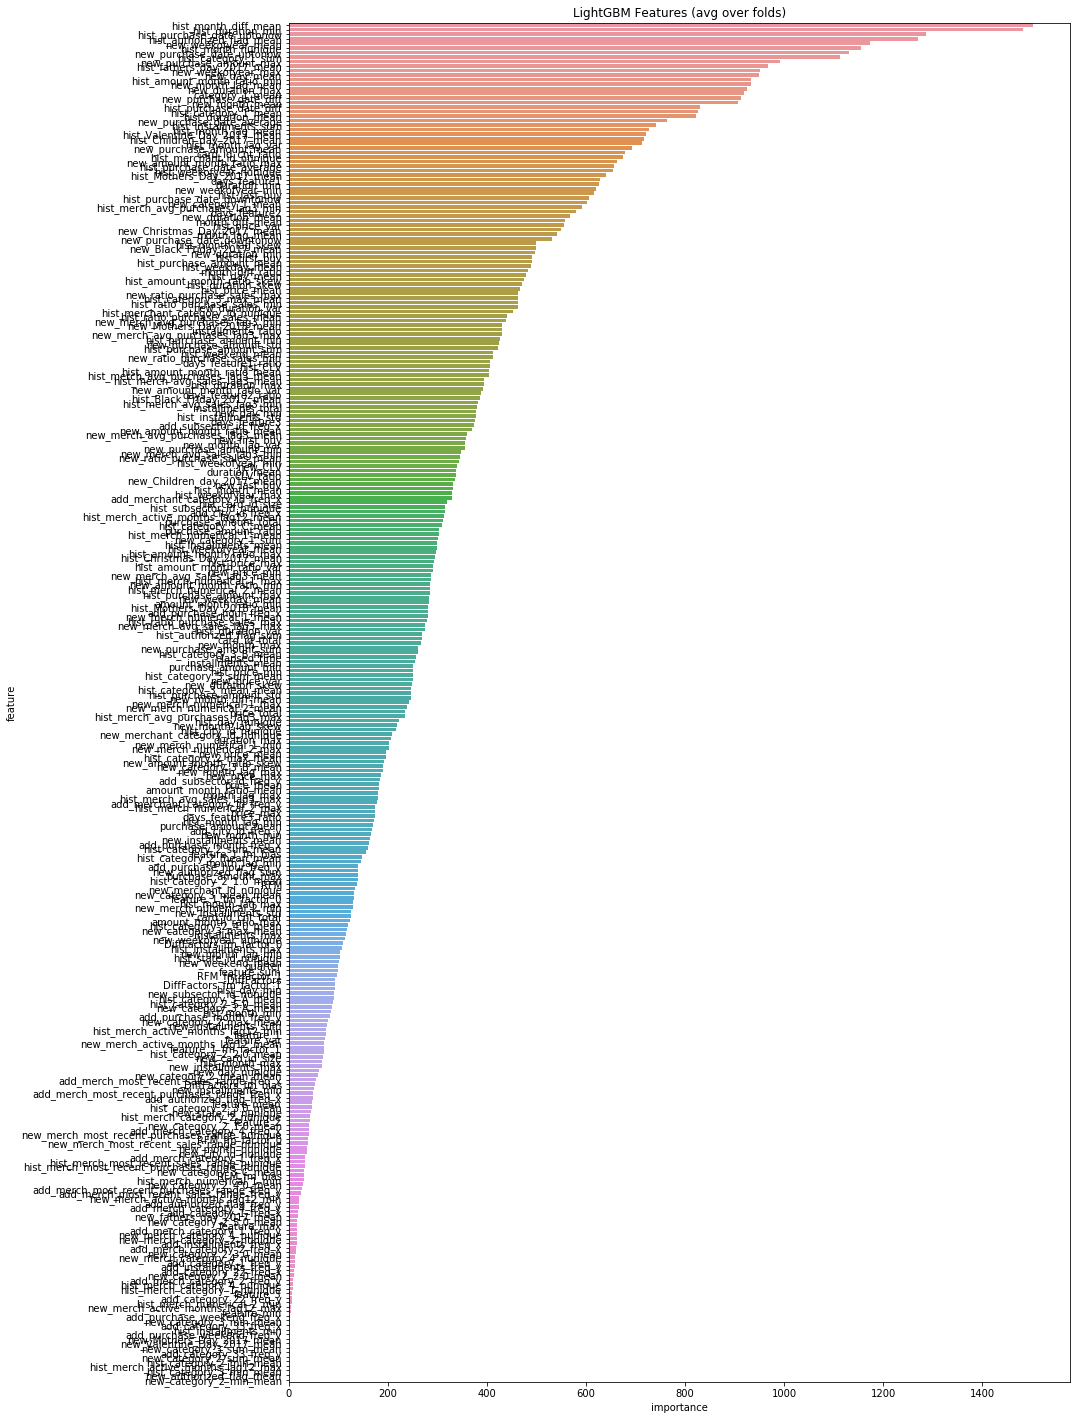

In [37]:
#3.6502249274802487
cols=(feature_importance_df.groupby('feature').mean().sort_values(by="importance", ascending=False))
cols.reset_index(drop=False,inplace=True)
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
           data=cols)
plt.title('LightGBM Features (avg over folds)')
plt.show()

In [56]:
#cols[cols['feature']=='feature_1_fm_factor_0']
cols

,feature,importance
0,hist_month_diff_mean,1501.6
1,hist_duration_min,1481.8
2,hist_purchase_date_uptonow,1286.2
3,hist_authorized_flag_mean,1270.6
4,new_weekofyear_mean,1173.8
5,hist_month_nunique,1155.4
6,new_purchase_date_uptonow,1131.0
7,hist_category_1_sum,1113.0
8,new_purchase_amount_max,990.6
9,hist_fathers_day_2017_mean,968.0


In [57]:
df_train

,Unnamed: 0,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_merchant_id_nunique,hist_day_nunique,hist_day_mean,...,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio,outliers,RFM,DiffFactors
0,0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,94,31,15.484375,...,23.843166,-0.104797,-0.132935,0.163521,-26.234375,-3855.066162,0.006805,0,3,1
1,1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822,142,31,16.656250,...,51.773972,-0.105530,-0.122925,0.299874,-2.089844,-6304.522949,0.000332,0,3,7
2,2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.687988,13,19,19.234375,...,-9.306469,-0.122253,-0.128662,-0.076913,-0.063660,-113.420059,0.000561,0,2,0
3,3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142456,50,25,16.921875,...,9.504578,-0.113037,-0.128540,0.084177,-2.783203,-444.877502,0.006256,0,2,0
4,4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159790,66,30,15.773438,...,84.534584,-0.078857,-0.134644,0.691490,-61.625000,-643.978394,0.095703,0,7,7
5,5,2016-09-01,C_ID_0894217f2f,4,2,0,0.871582,22,17,18.031250,...,0.638957,-0.040833,-0.070190,0.001770,-0.294678,-24.433739,0.012054,0,4,5
6,6,2016-12-01,C_ID_7e63323c00,3,2,1,0.230103,63,31,13.070312,...,-14.795532,-0.120605,-0.129272,-0.103267,-1.500977,-4119.877930,0.000364,0,3,0
7,7,2017-09-01,C_ID_dfa21fc124,3,2,1,2.136719,9,10,20.640625,...,-9.788401,-0.100952,-0.111145,-0.054402,-0.471924,-38.016148,0.012413,0,2,0
8,8,2017-08-01,C_ID_fe0fdac8ea,2,1,0,-0.065430,8,8,5.933594,...,-9.983880,-0.103577,-0.124207,-0.069333,-0.219727,-10.885468,0.020187,0,0,5
9,9,2016-08-01,C_ID_bf62c0b49d,2,2,0,0.300049,59,25,12.507812,...,-12.076874,-0.116699,-0.129272,-0.086463,-0.535156,-782.990356,0.000683,0,7,5


In [11]:
df_train['DiffFactors'].corr(df_train['target'])

-0.02455946265100896

In [27]:
n_epochs = 100
P = 17

batch_size = 2**P
print(batch_size)
model, model_features = build_model_1(x_train, f_size)
earlystopper = EarlyStopping(patience=0, verbose=1)

model.fit(x_train,  y_train, 
          epochs=n_epochs, batch_size=batch_size, verbose=1, shuffle=True, 
          validation_data=(x_train, y_train),
          callbacks=[earlystopper],
         )

131072
Train on 28 samples, validate on 28 samples
Epoch 1/100
28/28 [==============================] - 2s 73ms/step - loss: 43.0751 - val_loss: 42.9941
Epoch 2/100
28/28 [==============================] - 0s 0us/step - loss: 43.0156 - val_loss: 42.9244
Epoch 3/100
28/28 [==============================] - 0s 557us/step - loss: 42.9574 - val_loss: 42.8556
Epoch 4/100
28/28 [==============================] - 0s 0us/step - loss: 42.9003 - val_loss: 42.7875
Epoch 5/100
28/28 [==============================] - 0s 0us/step - loss: 42.8444 - val_loss: 42.7203
Epoch 6/100
28/28 [==============================] - 0s 0us/step - loss: 42.7897 - val_loss: 42.6538
Epoch 7/100
28/28 [==============================] - 0s 0us/step - loss: 42.7362 - val_loss: 42.5881
Epoch 8/100
28/28 [==============================] - 0s 0us/step - loss: 42.6838 - val_loss: 42.5232
Epoch 9/100
28/28 [==============================] - 0s 557us/step - loss: 42.6326 - val_loss: 42.4591
Epoch 10/100
28/28 [===============

Epoch 81/100
28/28 [==============================] - 0s 0us/step - loss: 37.6402 - val_loss: 36.3229
Epoch 82/100
28/28 [==============================] - 0s 0us/step - loss: 37.5387 - val_loss: 36.1901
Epoch 83/100
28/28 [==============================] - 0s 0us/step - loss: 37.4374 - val_loss: 36.0575
Epoch 84/100
28/28 [==============================] - 0s 0us/step - loss: 37.3362 - val_loss: 35.9252
Epoch 85/100
28/28 [==============================] - 0s 557us/step - loss: 37.2351 - val_loss: 35.7925
Epoch 86/100
28/28 [==============================] - 0s 0us/step - loss: 37.1337 - val_loss: 35.6611
Epoch 87/100
28/28 [==============================] - 0s 557us/step - loss: 37.0332 - val_loss: 35.5303
Epoch 88/100
28/28 [==============================] - 0s 0us/step - loss: 36.9329 - val_loss: 35.4001
Epoch 89/100
28/28 [==============================] - 0s 0us/step - loss: 36.8330 - val_loss: 35.2696
Epoch 90/100
28/28 [==============================] - 0s 0us/step - loss: 36.7

In [29]:
x_pred = model_features.predict(x_train, batch_size=batch_size)

In [33]:
factors = x_pred[:len(features)]

biases = x_pred[len(features):2*len(features)]

for f, x_p in zip(features, factors):
    for i in range(k_latent):
        x['%s_fm_factor_%d' % (f, i)] = x_p[:,i]

for f, x_p in zip(features, biases):
    x['%s_fm_bias' % (f)] = x_p[:,0]
x

,feature_1,feature_2,feature_3,num,feature_1_fm_factor_0,feature_1_fm_factor_1,feature_2_fm_factor_0,feature_2_fm_factor_1,feature_3_fm_factor_0,feature_3_fm_factor_1,feature_1_fm_bias,feature_2_fm_bias,feature_3_fm_bias
0,1,1,0,8.780941,0.173210,-0.180180,-0.137567,-0.027890,0.136162,-0.179691,-0.038509,0.076555,0.070430
1,1,1,1,0.000000,0.173210,-0.180180,-0.137567,-0.027890,-0.159726,0.123954,-0.038509,0.076555,-0.041112
2,1,2,0,7.949444,0.173210,-0.180180,0.021806,0.061035,0.136162,-0.179691,-0.038509,-0.076778,0.070430
3,1,2,1,0.000000,0.173210,-0.180180,0.021806,0.061035,-0.159726,0.123954,-0.038509,-0.076778,-0.041112
4,1,3,0,7.899895,0.173210,-0.180180,-0.028694,0.076916,0.136162,-0.179691,-0.038509,-0.062667,0.070430
5,1,3,1,0.000000,0.173210,-0.180180,-0.028694,0.076916,-0.159726,0.123954,-0.038509,-0.062667,-0.041112
6,2,1,0,10.106551,0.153709,-0.147457,-0.137567,-0.027890,0.136162,-0.179691,-0.031915,0.076555,0.070430
7,2,1,1,0.000000,0.153709,-0.147457,-0.137567,-0.027890,-0.159726,0.123954,-0.031915,0.076555,-0.041112
8,2,2,0,10.105204,0.153709,-0.147457,0.021806,0.061035,0.136162,-0.179691,-0.031915,-0.076778,0.070430
9,2,2,1,0.000000,0.153709,-0.147457,0.021806,0.061035,-0.159726,0.123954,-0.031915,-0.076778,-0.041112


In [37]:
df_train2=df_train.merge(x.loc[:,x.columns!='num'],how='left',on=['feature_1','feature_2','feature_3'])
def test_result(df):
    data=df[['feature_1_fm_factor_0', 'feature_1_fm_factor_1', 'feature_2_fm_factor_0',
             'feature_2_fm_factor_1','feature_3_fm_factor_0','feature_3_fm_factor_1',
             'feature_1_fm_bias','feature_2_fm_bias','feature_3_fm_bias','target']]
    from sklearn.linear_model import Ridge
    model=Ridge()
    model.fit(data.loc[:,data.columns!='target'],data['target'])
    pr=model.predict(data.loc[:,data.columns!='target'])
    return np.sqrt(mean_squared_error(pr,data['target']))
test_result(df_train2)

3.8493589422452965